<a href="https://colab.research.google.com/github/Abhijeet10219/SmartHVAC-ML/blob/main/SmartHVAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib xgboost tensorflow scikit-learn keras

In [ ]:
!pip install scikeras

  Using cached keras-3.2.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [ ]:
!pip show tensorflow
!pip show keras

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras
Name: keras
Version: 3.2.1
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: scikeras, tensorflow


In [ ]:
# Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from tensorflow.keras.callbacks import EarlyStopping  # Change here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense  # Change here

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index is deprecated")

In [ ]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('/content/EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [ ]:
# Calculate total energy consumption by summing up heating and cooling loads
data['Energy Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

(768, 11)


**2. Dataset Summary**

In [ ]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [ ]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

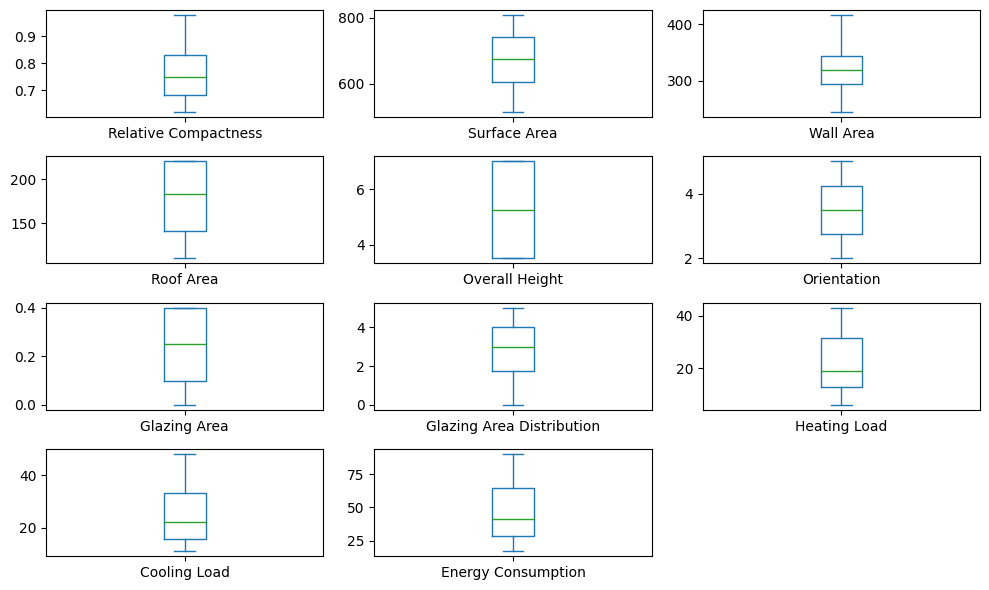

In [ ]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

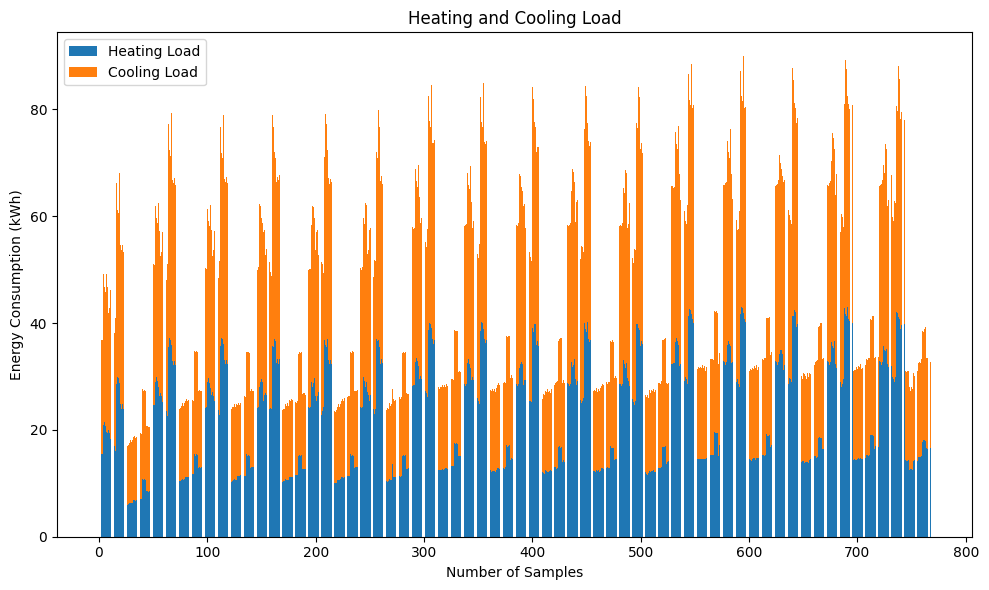

In [ ]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

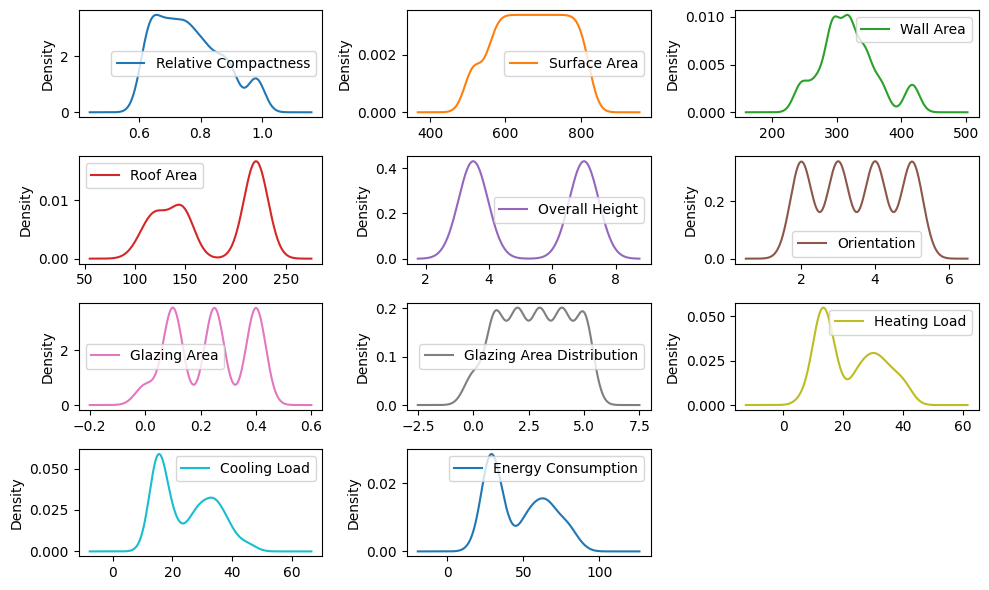

In [ ]:
# Create density plots to check the Gaussian distribution of features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions, except for the Surface Area. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

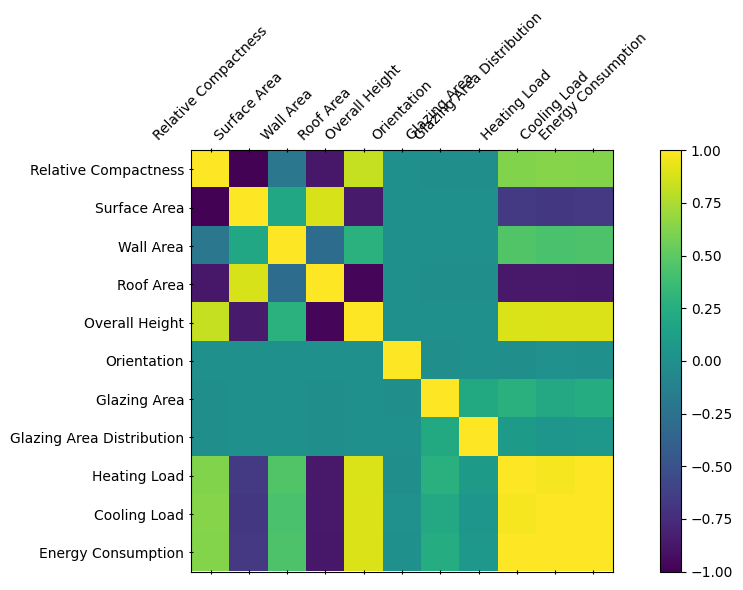

In [ ]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

According to the correlation matrix, the heating and cooling loads, as well as energy consumption, exhibit strong correlations with the overall height, orientation, and to some extent, the surface area. The orientation is considered to be an uncertain factor in building design due to limited choices compared to other variables and it plays a significant role in determining the energy efficiency of a building.

**3. Prepare Data**

In [ ]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy Consumption           700
dtype: int64


In [ ]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy Consumption           0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [ ]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy Consumption']).sort_values(ascending=False)

# filter columns with low correlation
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [ ]:
# b) Split-out dataset into train and validation sets

X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# For XGBoost model
X_train1 = X_train
y_train1 = y_train
X_val1 = X_val

(537, 8) (537,) (231, 8) (231,)


In [ ]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluate Algorithms**

In [ ]:
# a) Spot check algorithms using cross-validation technique
num_folds = 8
seed = 8

# Select 3 most popular algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))

# Define the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
models.append(('XGB', model_xgb))

In [ ]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Dense(300, input_shape = (8, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(200, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_NN = baseline_model()
models.append(('NN', model_NN))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # modify loop for xgboost and NN
    if name != ('XGB' and 'NN'):
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:
        if name == 'NN':
            validation_data = (X_val, y_val)
            cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 150})
        else:
            # create DMatrix from training data for XGBoost
            dtrain = xgb.DMatrix(X_train1, label=y_train1)
            cvs = cross_val_score(model_xgb, X_train1, y_train1, cv=kfold, scoring='neg_mean_squared_error')

    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

NameError: name 'KerasRegressor' is not defined

In [ ]:
# Plot learning curve of NN model
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

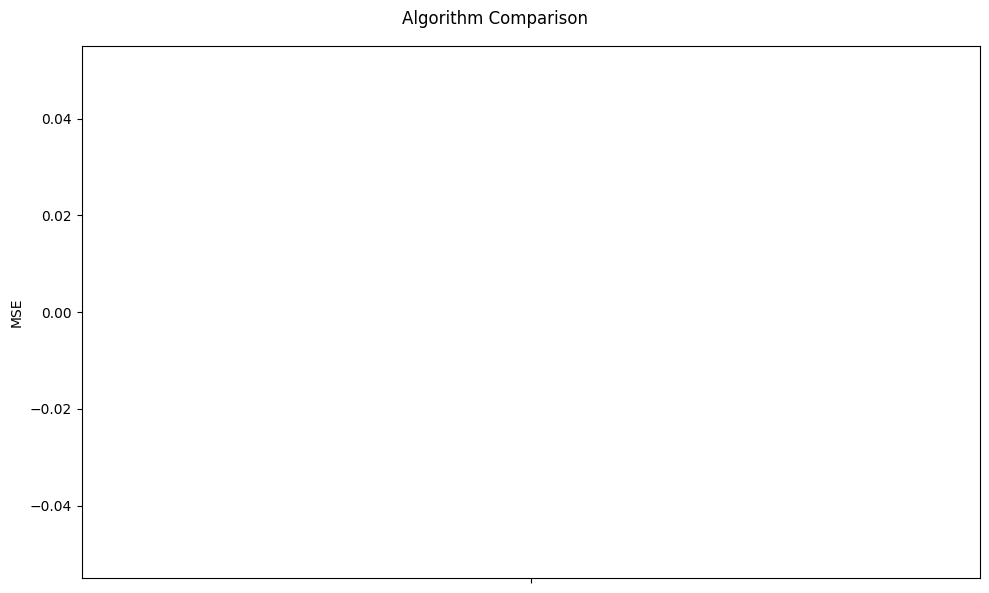

In [ ]:
# b) Compare algorithms and the NN model
# Distribution of accuracy values calculated across 8 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

Of the three algorithms and NN model, the ensemble models outperformed Linear Regression and NN model.

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data.

In [ ]:
# Evaluate performance of Random Forest algorithm on validation data
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  1.30604329004329


In [ ]:
# Evaluate performance of XGBoost algorithm on validation data
model_xgb.fit(X_train1, y_train1)
dtrain = xgb.DMatrix(X_val1)
y_pred_xgb = model_xgb.predict(X_val1)
mae_pred_xgb = mean_absolute_error(y_val, y_pred_xgb)
print("Mean Absolute Error of predicted data: ", mae_pred_xgb)

Mean Absolute Error of predicted data:  1.42965223304121


In [ ]:
# Define baseline mean_absolute_error of y_val in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  17.70811874323593


The resulting MAE values show that Random Forest looks better than XGBoost in prediction performance. For the sake of simplicity, I selected Random Forest as the surrogate model for the optimization process in the 2nd Notebook.

**5. Finalize Model**

In [ ]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


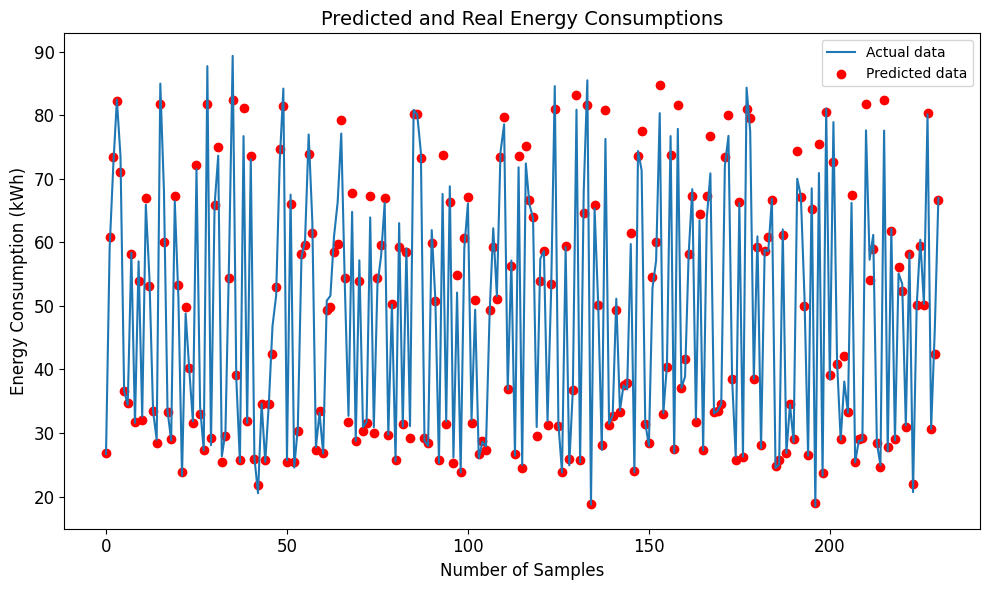

In [ ]:
fig, ax = plt.subplots()

# Plot the actual data as a line chart
ax.plot(range(len(y_val)), y_val, label='Actual data')

# Overlay the predicted data as a scatter plot
ax.scatter(range(len(y_pred_RF)), y_pred_RF, label='Predicted data', color='red')

# Add labels, title, and legend
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.set_title('Predicted and Real Energy Consumptions', fontsize=14)
ax.legend()

# set tick font size for both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [ ]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_RF, open(filename, 'wb'))